In [ ]:
import tensorflow as tf           # Deep learning framework
import keras                      # High-level neural networks API (built on top of TensorFlow)
import numpy as np                # Numerical computations
import pandas as pd               # Data manipulation and analysis
import matplotlib.pyplot as plt   # Data visualization
import os                         # File and images reading
import cv2                        # images reading and cropping

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive


In [ ]:
#!unzip data.zip

In [ ]:
Training = []
Name = []
for dirname, _, filenames in os.walk('data/'):
    Temp = []
    if len(filenames) >= 31:
        pass
    else:
        continue
    for filename in filenames:
        if "png" in filename:
            img = cv2.imread(os.path.join(dirname, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            Temp.append(img)
    Temp = np.stack(Temp, axis=-1)
    Training.append(Temp)
    Name.append(dirname.split("/")[-1])
np.array(Training).shape, np.array(Name).shape

((32, 512, 512, 31), (32,))

In [ ]:
# Crop the hyperspectral image into smaller images
Temp = []
for img in Training:
    for y in range(0, 512-64+1, 32):
        for x in range(0, 512-64+1, 32):
            # Crop the hyperspectral image
            cropped_image = img[y:y+64, x:x+64, :]
            Temp.append(cropped_image)
Training = Temp
np.array(Training).shape

(7200, 64, 64, 31)

In [ ]:
LR = []
for img in Training:
    low_res = np.zeros((8, 8, 31))
    for band in range(31):
        band_img = img[:, :, band]
        band_img = cv2.resize(band_img, (8, 8), interpolation=cv2.INTER_AREA)
        low_res[:, :, band] = band_img
    LR.append(low_res)
np.array(LR).shape

(7200, 8, 8, 31)

In [ ]:
HR = []
for img in Training:
    h_res = np.zeros((64, 64, 3))
    
    ch_1 = np.mean(img[:, :, 0:10], axis=2)
    h_res[:, :, 0] = ch_1
    
    ch_2 = np.mean(img[:, :, 10:20], axis=2)
    h_res[:, :, 1] = ch_2
    
    ch_3 = np.mean(img[:, :, 20:31], axis=2)
    h_res[:, :, 2] = ch_3

    # Normalize the high-resolution RGB image to the range [0, 255]
    h_res = (h_res-np.min(h_res))/(np.max(h_res)-np.min(h_res))*255

    h_res = h_res.astype(np.uint8)
    
    HR.append(h_res)
np.array(HR).shape

(7200, 64, 64, 3)

In [ ]:
from keras.api._v2.keras import activations
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

def build_model():
    # Input layers for two images
    input1 = layers.Input(shape=(8, 8, 31))
    input2 = layers.Input(shape=(64, 64, 3))
    
    # Convolutional layers for image 1
    conv1 = layers.Conv2D(32, (1, 1), activation='relu')(input2)
    conv2 = layers.Conv2D(64, (1, 1), activation='relu')(conv1)
    
    # Convolutional layers for image 2
    conv3 = layers.Conv2D(32, (1, 1), activation='relu')(input1)
    upsample1 = layers.UpSampling2D((8,8))(conv3)
    conv4 = layers.Conv2D(64, (1, 1), activation='relu')(upsample1)
    
    # Concatenate the output feature maps from the two branches
    concatenated = layers.Concatenate(axis=-1)([conv2, conv4])
    
    output = layers.Conv2D(64, (1,1), activation="relu")(concatenated)
    output = layers.Conv2D(31, (1, 1), activation='relu')(output)

    # Create the model
    model = Model(inputs=[input1, input2], outputs=output)
    return model

# Build the model
model = build_model()
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_absolute_percentage_error"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 8, 31)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 32)     1024        ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   128         ['input_2[0][0]']                
                                                                                              

In [ ]:
LR_Train = np.array(LR[:1000])
HR_Train = np.array(HR[:1000])
Training_Train = np.array(Training[:1000])

LR_Test = np.array(LR[1500:2000])
HR_Test = np.array(HR[1500:2000])
Training_Test = np.array(Training[1500:2000])

In [ ]:
history = model.fit(x=[LR_Train, HR_Train], y=Training_Train, epochs=75, batch_size=50)

Epoch 1/75
20/20 [==============================] - 14s 635ms/step - loss: 1927.7633 - mean_absolute_percentage_error: 78432576.0000
Epoch 2/75
20/20 [==============================] - 13s 635ms/step - loss: 1003.3950 - mean_absolute_percentage_error: 100707224.0000
Epoch 3/75
20/20 [==============================] - 13s 632ms/step - loss: 557.3029 - mean_absolute_percentage_error: 60459908.0000
Epoch 4/75
20/20 [==============================] - 12s 627ms/step - loss: 362.5454 - mean_absolute_percentage_error: 41490224.0000
Epoch 5/75
20/20 [==============================] - 13s 658ms/step - loss: 272.8407 - mean_absolute_percentage_error: 33011302.0000
Epoch 6/75
20/20 [==============================] - 21s 1s/step - loss: 184.9697 - mean_absolute_percentage_error: 27023854.0000
Epoch 7/75
20/20 [==============================] - 13s 637ms/step - loss: 161.1395 - mean_absolute_percentage_error: 23256250.0000
Epoch 8/75
20/20 [==============================] - 13s 632ms/step - loss: 1

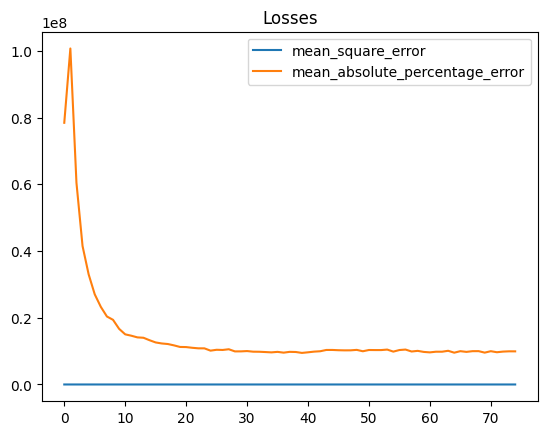

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_percentage_error"])
plt.legend(["mean_square_error", "mean_absolute_percentage_error"])
plt.title("Losses")
plt.show()

In [ ]:
Pre = model.predict(x=[LR_Test, HR_Test])

16/16 [==============================] - 2s 104ms/step


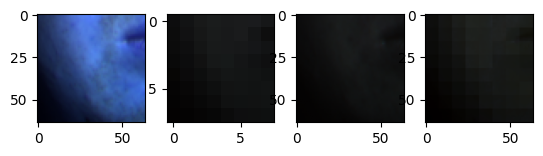

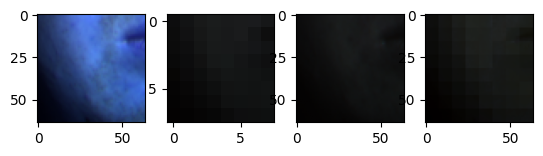

In [ ]:
import random
for i in range(2):
  j = random.randint(0, len(HR_Test)-1)
  plt.subplot(1, 4, 1)
  plt.imshow(HR_Test[j]/255)
  plt.subplot(1, 4, 2)
  plt.imshow(LR_Test[j][:, :, 1:4]/255)
  plt.subplot(1, 4, 3)
  plt.imshow(Training_Test[j][:, :, 1:4]/255)
  plt.subplot(1, 4, 4)
  plt.imshow(Pre[j][:, :, 1:4]/255)
  plt.show()